In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

# Tutorial 6  
Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[paper](https://arxiv.org/pdf/1611.07308.pdf)  
[code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

## Graph AutoEncoder GAE

### Load the data

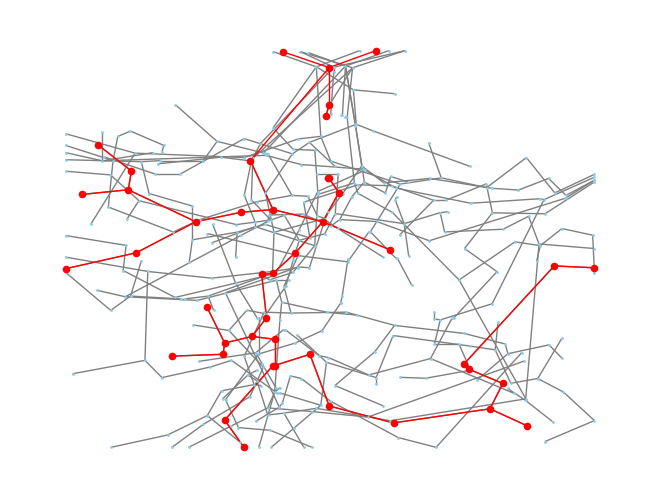

In [ ]:
import json
import torch as tf
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx


# Load the graph list from maples.json
with open('skeletons-mst-normalized.json', 'r') as file:
    graphs = json.load(file)

G = nx.Graph()

for graph in graphs[:10]:
  g = nx.node_link_graph(graph)
  G = nx.compose(G, g)

first_g = nx.node_link_graph(graphs[0])
data = from_networkx(G)

#concatenate pos (x,y) and is_trunk
# data.x = torch.cat([data.pos, data.is_trunk.unsqueeze(-1)], dim=-1)

#ignore the weights of the edges for now
data.weight = None

data.x = data.pos

data.pos = None

#is_trunk redundant
data.is_trunk = None

data

import matplotlib.pyplot as plt

pos = {node: (G.nodes[node]['pos'][0], G.nodes[node]['pos'][1]) for node in G.nodes}
first_g_pos = {node: (first_g.nodes[node]['pos'][0], first_g.nodes[node]['pos'][1]) for node in first_g.nodes}
# pos
# # Draw the graph
nx.draw(G, pos, node_color='skyblue', node_size=1, edge_color='gray')
nx.draw(first_g, first_g_pos, node_color='red', node_size=20, edge_color='red')

# # Show the plot
plt.show()

In [ ]:
#data.train_mask = data.val_mask = data.test_mask = None
data.weight = None

In [ ]:
data = train_test_split_edges(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
data

Data(x=[4409, 2], val_pos_edge_index=[2, 232], test_pos_edge_index=[2, 465], train_pos_edge_index=[2, 7906], train_neg_adj_mask=[4409, 4409], val_neg_edge_index=[2, 232], test_neg_edge_index=[2, 465])

### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

### Define the Autoencoder

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 2
num_features = 2
epochs = 300

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    # return F.mse_loss(reconstructed_adj, original_adj)

    return model.test(z, pos_edge_index, neg_edge_index)



In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.5206, AP: 0.5750
Epoch: 002, AUC: 0.5273, AP: 0.5778
Epoch: 003, AUC: 0.5377, AP: 0.5819
Epoch: 004, AUC: 0.5466, AP: 0.5850
Epoch: 005, AUC: 0.5551, AP: 0.5891
Epoch: 006, AUC: 0.5638, AP: 0.5935
Epoch: 007, AUC: 0.5718, AP: 0.5972
Epoch: 008, AUC: 0.5802, AP: 0.6011
Epoch: 009, AUC: 0.5887, AP: 0.6050
Epoch: 010, AUC: 0.5973, AP: 0.6094
Epoch: 011, AUC: 0.6050, AP: 0.6131
Epoch: 012, AUC: 0.6118, AP: 0.6163
Epoch: 013, AUC: 0.6176, AP: 0.6193
Epoch: 014, AUC: 0.6215, AP: 0.6214
Epoch: 015, AUC: 0.6250, AP: 0.6235
Epoch: 016, AUC: 0.6276, AP: 0.6252
Epoch: 017, AUC: 0.6297, AP: 0.6265
Epoch: 018, AUC: 0.6309, AP: 0.6272
Epoch: 019, AUC: 0.6320, AP: 0.6280
Epoch: 020, AUC: 0.6325, AP: 0.6285
Epoch: 021, AUC: 0.6327, AP: 0.6286
Epoch: 022, AUC: 0.6306, AP: 0.6271
Epoch: 023, AUC: 0.6282, AP: 0.6257
Epoch: 024, AUC: 0.6271, AP: 0.6250
Epoch: 025, AUC: 0.6277, AP: 0.6252
Epoch: 026, AUC: 0.6298, AP: 0.6265
Epoch: 027, AUC: 0.6333, AP: 0.6286
Epoch: 028, AUC: 0.6386, AP:

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z
# print(Z)
# print(train_pos_edge_index)
# len(Z)
# print(len(train_pos_edge_index[0]))

tensor([[-0.4562,  0.7984,  0.1987],
        [-0.2075, -0.4754,  0.9141],
        [ 0.5352, -0.8069, -0.1303],
        ...,
        [-0.4491,  0.4884,  0.4499],
        [ 0.5867, -0.8425, -0.1681],
        [ 0.7269, -0.8864, -0.3589]], grad_fn=<AddBackward0>)

## Are the results (AUC) and (AP) easy to read and compare?

# Use Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# parameters
out_channels = 5
num_features = 2
epochs = 300

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Import tensorboard

#### Installation: (if needed) "pip install tensorboard"

In [ ]:
writer = SummaryWriter('runs/GAE1_experiment_SMALL_'+'2d_5f_300_epochs')

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))


    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.7528, AP: 0.6609
Epoch: 002, AUC: 0.7535, AP: 0.6612
Epoch: 003, AUC: 0.7535, AP: 0.6633
Epoch: 004, AUC: 0.7548, AP: 0.6683
Epoch: 005, AUC: 0.7548, AP: 0.6683
Epoch: 006, AUC: 0.7548, AP: 0.6683
Epoch: 007, AUC: 0.7542, AP: 0.6639
Epoch: 008, AUC: 0.7528, AP: 0.6607
Epoch: 009, AUC: 0.7521, AP: 0.6597
Epoch: 010, AUC: 0.7514, AP: 0.6574
Epoch: 011, AUC: 0.7507, AP: 0.6556
Epoch: 012, AUC: 0.7514, AP: 0.6591
Epoch: 013, AUC: 0.7521, AP: 0.6595
Epoch: 014, AUC: 0.7521, AP: 0.6657
Epoch: 015, AUC: 0.7528, AP: 0.6660
Epoch: 016, AUC: 0.7535, AP: 0.6746
Epoch: 017, AUC: 0.7542, AP: 0.6751
Epoch: 018, AUC: 0.7528, AP: 0.6661
Epoch: 019, AUC: 0.7528, AP: 0.6664
Epoch: 020, AUC: 0.7535, AP: 0.6670
Epoch: 021, AUC: 0.7528, AP: 0.6661
Epoch: 022, AUC: 0.7528, AP: 0.6662
Epoch: 023, AUC: 0.7535, AP: 0.6670
Epoch: 024, AUC: 0.7521, AP: 0.6598
Epoch: 025, AUC: 0.7528, AP: 0.6603
Epoch: 026, AUC: 0.7521, AP: 0.6598
Epoch: 027, AUC: 0.7535, AP: 0.6631
Epoch: 028, AUC: 0.7542, AP:

## Graph Variational AutoEncoder (GVAE)

In [ ]:
from torch_geometric.nn import VGAE

In [ ]:
# dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
# data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None

with open('skeletons-mst-normalized.json', 'r') as file:
    graphs = json.load(file)

G = nx.Graph()

for graph in graphs[:10]:
  g = nx.node_link_graph(graph)
  G = nx.compose(G, g)

first_g = nx.node_link_graph(graphs[0])
data = from_networkx(G)

#concatenate pos (x,y) and is_trunk
# data.x = torch.cat([data.pos, data.is_trunk.unsqueeze(-1)], dim=-1)

#ignore the weights of the edges for now
data.weight = None

data.x = data.pos

#ignore the weights of the edges for now
data.weight = None

#is_trunk redundant
data.is_trunk = None

data

data = train_test_split_edges(data)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
out_channels = 4
num_features = 2
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import shutil
shutil.make_archive('runs', 'zip', 'runs')

'/content/runs.zip'

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
writer = SummaryWriter('runs/VGAE_experiment_SMALL_'+'2d_4f_300_epochs')

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))


    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.6316, AP: 0.5697
Epoch: 002, AUC: 0.6440, AP: 0.5752
Epoch: 003, AUC: 0.6537, AP: 0.5836
Epoch: 004, AUC: 0.6634, AP: 0.5912
Epoch: 005, AUC: 0.6676, AP: 0.5970
Epoch: 006, AUC: 0.6731, AP: 0.6010
Epoch: 007, AUC: 0.6828, AP: 0.6098
Epoch: 008, AUC: 0.6974, AP: 0.6241
Epoch: 009, AUC: 0.7050, AP: 0.6458
Epoch: 010, AUC: 0.7168, AP: 0.6624
Epoch: 011, AUC: 0.7327, AP: 0.6846
Epoch: 012, AUC: 0.7438, AP: 0.6939
Epoch: 013, AUC: 0.7458, AP: 0.6956
Epoch: 014, AUC: 0.7465, AP: 0.6958
Epoch: 015, AUC: 0.7410, AP: 0.6815
Epoch: 016, AUC: 0.7389, AP: 0.6793
Epoch: 017, AUC: 0.7361, AP: 0.6738
Epoch: 018, AUC: 0.7334, AP: 0.6704
Epoch: 019, AUC: 0.7285, AP: 0.6544
Epoch: 020, AUC: 0.7271, AP: 0.6517
Epoch: 021, AUC: 0.7258, AP: 0.6507
Epoch: 022, AUC: 0.7223, AP: 0.6434
Epoch: 023, AUC: 0.7209, AP: 0.6395
Epoch: 024, AUC: 0.7230, AP: 0.6426
Epoch: 025, AUC: 0.7251, AP: 0.6452
Epoch: 026, AUC: 0.7334, AP: 0.6531
Epoch: 027, AUC: 0.7348, AP: 0.6599
Epoch: 028, AUC: 0.7341, AP: